# No_balancing Method

This notebook will apply the no_balancing balancing method to the training data.

In [10]:
import pandas as pd

df_train = pd.read_csv('train.csv')
X_train = df_train.drop('Diabetes_binary', axis=1)
y_train = df_train['Diabetes_binary']

val_df = pd.read_csv('val.csv')
X_val = val_df.drop('Diabetes_binary', axis=1)
y_val = val_df['Diabetes_binary']

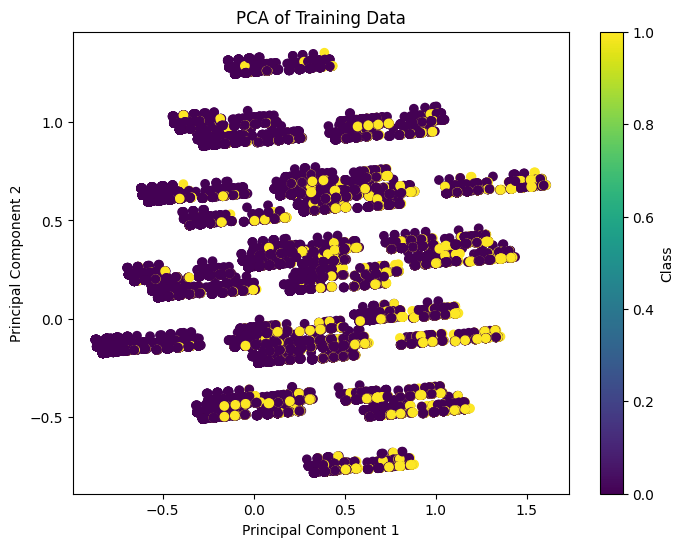

In [11]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Convert continuous values to binary class labels
y_train_binary = (y_train > 0.5).astype(int)

# Perform PCA with 2 components
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_binary, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.colorbar(label='Class')
plt.show()


In [13]:
svm_model = SVC(kernel='linear', class_weight='balanced')  # Add class_weight='balanced'
svm_model.fit(X_train_pca, y_train_binary)

# Test on validation set
y_pred = svm_model.predict(X_val_pca)

# Calculate evaluation metrics with zero_division parameter set to 1
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=1)  # Add zero_division=1
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, zero_division=1)  # Add zero_division=1

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[27262 16405]
 [ 1710  5359]]
Accuracy: 0.6429556922106591
Precision: 0.24623231023708878
Recall: 0.7580987409817513
F1 Score: 0.3717268407727257


In [7]:
import numpy as np
import cvxopt
import cvxopt.solvers
import pandas as pd

cvxopt.solvers.options['show_progress'] = False

class SVM_RBF:
    def __init__(self, C=1.0, gamma=10):
        self.C = C
        self.gamma = float(gamma)
        self._support_vectors = None
        self._alphas = None
        self.intercept = None
        self._support_labels = None

    def rbf_kernel(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * np.sum((x[:, np.newaxis] - y) ** 2, axis=2))

    def fit(self, data, labels):
        data_np = data.values if isinstance(data, pd.DataFrame) else data
        labels_np = labels.values if isinstance(labels, pd.Series) else labels

        num_data, num_features = data_np.shape
        labels_np = labels_np.astype(np.double)

        K = self.rbf_kernel(data_np, data_np)

        P = cvxopt.matrix(np.outer(labels_np, labels_np) * K)
        q = cvxopt.matrix(np.ones(num_data) * -1)
        A = cvxopt.matrix(labels_np, (1, num_data), 'd')
        b = cvxopt.matrix(0.0)

        G_max = cvxopt.matrix(np.diag(np.ones(num_data) * -1))
        G_min = cvxopt.matrix(np.diag(np.ones(num_data)))
        G = cvxopt.matrix(np.vstack((G_max, G_min)))
        h_max = cvxopt.matrix(np.zeros(num_data))
        h_min = cvxopt.matrix(np.ones(num_data) * self.C)
        h = cvxopt.matrix(np.vstack((h_max, h_min)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])
        sv_mask = alphas > 1e-5
        self._support_vectors = data_np[sv_mask]
        self._alphas = alphas[sv_mask]
        self._support_labels = labels_np[sv_mask]

        # Calculate the intercept with corrected indexing
        sv_indices = np.where(sv_mask)[0]  # Indices of support vectors
        self.intercept = np.mean([
            y_k - np.sum(
                self._alphas * self._support_labels * K[i, sv_indices]
            ) for i, y_k in zip(sv_indices, self._support_labels)
        ])

    def predict(self, X):
        if self._alphas is None or self._support_labels is None:
            raise ValueError("SVM model has not been trained. Call the 'fit' method first.")

        X_np = X.values if isinstance(X, pd.DataFrame) else X
        K = self.rbf_kernel(X_np, self._support_vectors)
        score = np.dot(K, self._alphas * self._support_labels) + self.intercept
        return np.sign(score)

# Example usage (ensure you have defined X_val, y_val, and trained the model):
# svm_rbf = SVM_RBF(C=1.0, gamma=0.1)
# svm_rbf.fit(X_train, y_train)
# y_pred_rbf = svm_rbf.predict(X_val)
# print("SVM with RBF kernel - Classification Report on Validation Set:")
# print_classification_report(y_val, y_pred_rbf)


In [9]:
def print_classification_report(y_true, y_pred):
    """
    Prints a simple classification report including precision, recall, and F1-score for each class.
    """
    classes = np.unique(y_true)
    print("Class\tPrecision\tRecall\t\tF1-Score")
    
    for cls in classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{cls}\t{precision:.2f}\t\t{recall:.2f}\t\t{f1_score:.2f}")


subset_size = 10000  # Adjust based on your dataset size and system capabilities
svm_rbf = SVM_RBF(C=1.0, gamma=0.1)
svm_rbf.fit(X_train[:subset_size], y_train[:subset_size])
y_pred_rbf = svm_rbf.predict(X_val[:subset_size])
print("SVM with RBF kernel - Classification Report on Validation Set (Subset):")
print_classification_report(y_val[:subset_size], y_pred_rbf)



SVM with RBF kernel - Classification Report on Validation Set (Subset):
Class	Precision	Recall		F1-Score
0.0	0.86		1.00		0.92
1.0	0.00		0.00		0.00


<h2>SVM + rbf kernel</h2>

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', gamma='scale')
svm_rbf.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_rbf = svm_rbf.predict(X_val)
print("SVM with RBF kernel - Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_rbf))

SVM with RBF kernel - Classification Report on Validation Set:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     43667
         1.0       0.63      0.05      0.10      7069

    accuracy                           0.86     50736
   macro avg       0.75      0.52      0.51     50736
weighted avg       0.83      0.86      0.81     50736



<h2>SVM + Polynomial Kernel</h2>

In [4]:
svm_poly = SVC(kernel='poly', degree=3, gamma='scale')
svm_poly.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_poly = svm_poly.predict(X_val)
print("SVM with Polynomial kernel - Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_poly))

SVM with Polynomial kernel - Classification Report on Validation Set:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43667
         1.0       0.59      0.05      0.09      7069

    accuracy                           0.86     50736
   macro avg       0.73      0.52      0.51     50736
weighted avg       0.83      0.86      0.81     50736



<h2>SVM + Sigmoid Kernel</h2>

In [5]:
svm_sigmoid = SVC(kernel='sigmoid', gamma='scale')
svm_sigmoid.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_sigmoid = svm_sigmoid.predict(X_val)
print("SVM with Sigmoid kernel - Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_sigmoid))

SVM with Sigmoid kernel - Classification Report on Validation Set:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86     43667
         1.0       0.12      0.12      0.12      7069

    accuracy                           0.76     50736
   macro avg       0.49      0.49      0.49     50736
weighted avg       0.75      0.76      0.76     50736

